# GDAL Basics in Python

Task: calculate the NDVI for the region of interest (Cincinnati Metropolitan Area) using only gdal (I know rasterio, shapely and friends can do it in a friendly manner :) )

![Pipeline](img/ex1header.png)

**Answer:** We will proceed in the following steps

Part 1: 

1. Load initial landsat-8 imagery

2. Select appropriate bands for NDVI (Red and NIR)

3. Convert those bands to NUMPY space

4. Perform NDVI equation avoiding null calculations

5. creates an empty band and write back the result into it

Part 2:

6. Load shapefile

7. Transform shapefile in order to have the same space coordinates

8. Mask the result using the projected shapefile




## 1.1. Load initial landsat-8 imagery

In [1]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
from osgeo import ogr, osr, gdal


In [2]:
redfn='LC08_L1TP_020033_20180929_20200830_02_T1_B4.tiff'
nirfn='LC08_L1TP_020033_20180929_20200830_02_T1_B5.tiff'

In [3]:
def openRaster(fn,access=0):
    ds=gdal.Open(fn,access)
    if ds is None:
        print("Error opening raster dataset")
    return ds  

def getBandAsNP(infn,bandId=1,access=0):
    ds=openRaster(infn,access)
    band=ds.GetRasterBand(bandId).ReadAsArray()
    return (band)

def myNormalizer(imIn):
     """Normalizes numpy arrays into scale 0.0 - 1.0"""
     array_min, array_max = imIn.min(), imIn.max()
     return ((imIn - array_min)/(array_max - array_min))

According to USGS, let's load our bands of interest (B4, B5)

In [4]:
rtif=openRaster(redfn,0)

ntif=openRaster(nirfn,0)

## 1.2. Numpy conversion

We need to extract raster data to a more friendly format (Numpy)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 0.0


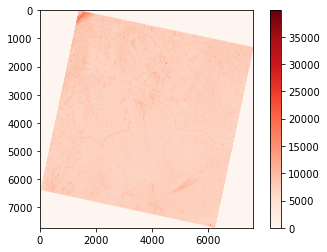

In [5]:
rband=getBandAsNP(redfn,1,0)
nvalue=rtif.GetRasterBand(1).GetNoDataValue()
print(rband,nvalue)
plt.imshow(rband,cmap='Reds')
plt.colorbar()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 0.0


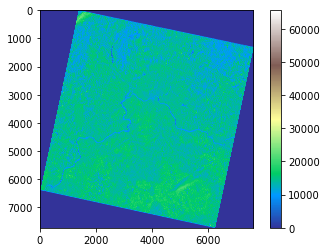

In [6]:
nband=getBandAsNP(nirfn,1,0)
nvaluenir=ntif.GetRasterBand(1).GetNoDataValue()
print(nband,nvaluenir)
plt.imshow(nband,cmap='terrain')
plt.colorbar()

Let's check the basic stats for each red and near infrared band:

In [7]:
print("Stats")
print(rband.min(), '-', rband.max(), 'mean:', rband.mean())
print(nband.min(), '-', nband.max(), 'mean:', nband.mean())

Stats
0 - 39845 mean: 5184.869625736499
0 - 65535 mean: 10053.943609493479


It seems they are in different scales. We need to rescale them properly before any operation.

In [8]:
rbandNorm=myNormalizer(rband)
nbandNorm=myNormalizer(nband)

print("Normalized bands")
print(rbandNorm.min(), '-', rbandNorm.max(), 'mean:', rbandNorm.mean())
print(nbandNorm.min(), '-', nbandNorm.max(), 'mean:', nbandNorm.mean())

Normalized bands
0.0 - 1.0 mean: 0.13012597881130641
0.0 - 1.0 mean: 0.15341334568541215


They are in the same scale. 

## 1.3. NDVI 

Now, we can simply apply the equation:

$ NDVI = \frac{(NIR-Red)}{(NIR+Red)} $

Depending of the Null value for each raster, there are several ways to avoid NAN operations. For this case, we will just supress the python warning

In [9]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

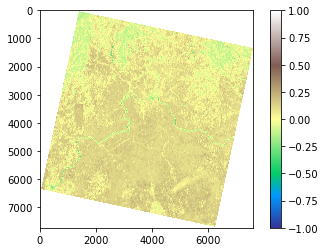

In [10]:
# normalized
ndvi = (nbandNorm - rbandNorm ) / ( nbandNorm + rbandNorm)
plt.imshow(ndvi,cmap='terrain')
plt.colorbar()

It is time to write our results using the gdal Driver.

In [11]:
# write the resulting image
outfn="ndvi_out.tif"
driver=gdal.GetDriverByName("GTiff")
outds=driver.Create(outfn,xsize=rtif.RasterXSize,ysize=rtif.RasterYSize,bands=1,eType=gdal.GDT_Float32)
outds.SetGeoTransform(rtif.GetGeoTransform())
outds.SetProjection(rtif.GetProjection())
outds.GetRasterBand(1).SetNoDataValue(nvalue)
outds.GetRasterBand(1).WriteArray(ndvi)
outds=None
rtif=None

# Part 2: Clip NDVI

Let's load our shapefile for cincinnati area.

In [12]:
#shapefile with the from projection
driver = ogr.GetDriverByName("ESRI Shapefile")
dataSource =   driver.Open("all7_in_1.shp", 0)
layer = dataSource.GetLayer()

Get the tranforms of interest:

In [13]:
#set spatial reference and transformation
sourceprj = layer.GetSpatialRef()
targetprj = osr.SpatialReference(wkt = ntif.GetProjection())
# A->B
target_transform = osr.CoordinateTransformation(sourceprj, targetprj)
print(sourceprj)
print(targetprj)

GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS 1980",6378137,298.257222101,
            AUTHORITY["EPSG","7019"]],
        AUTHORITY["EPSG","6269"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4269"]]
PROJCS["WGS 84 / UTM zone 16N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-87],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PAR

Can you spot the differences? The former is in NAD83 whereas the later is in WGS84. Let's create a new datasource for our projected polygon:

In [14]:
to_fill = ogr.GetDriverByName("Esri Shapefile")
ds = to_fill.CreateDataSource("cincy_prj.shp")
outlayer = ds.CreateLayer('', targetprj, ogr.wkbPolygon)
outlayer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))

0

Then, let's apply the transformation that we already grabbed from the first tiff file

In [15]:
#apply transformation
i = 0

for feature in layer:
    transformed = feature.GetGeometryRef()
    transformed.Transform(target_transform)

    geom = ogr.CreateGeometryFromWkb(transformed.ExportToWkb())
    defn = outlayer.GetLayerDefn()
    feat = ogr.Feature(defn)
    feat.SetField('id', i)
    feat.SetGeometry(geom)
    outlayer.CreateFeature(feat)
    i += 1
    feat = None


You can recheck yourself if the new shapefile is already in the right coordinates

In [16]:
#shpprj =   driver.Open("cincy_prj.shp", 0)
layerprj = ds.GetLayer()
sourceprj = layerprj.GetSpatialRef()
targetprj = osr.SpatialReference(wkt = ntif.GetProjection())
print(sourceprj)
print(targetprj)
ds=None

PROJCS["WGS 84 / UTM zone 16N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-87],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32616"]]
PROJCS["WGS 84 / UTM zone 16N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Gr

Finally, lets use gdalWarp to crop our area of interest

In [17]:
result=gdal.Warp("gdalClipped.tif","ndvi_out.tif",cutlineDSName="cincy_prj.shp",cropToCutline=True)

In order to perform the right clip, we check the crs of both objects (shapefile and raster)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


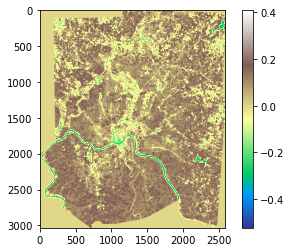

In [18]:
outtif=getBandAsNP("gdalClipped.tif",1,0)
print(outtif)
plt.imshow(outtif,cmap='terrain')
plt.colorbar()

## References

1. Great youtube channel https://www.youtube.com/watch?v=n33MswNARkE
2. For the proper installation of gdal https://medium.com/@nathancook_36247/launching-jupyter-notebook-from-the-command-line-can-be-more-powerful-than-using-anaconda-navigator-c7425cf1fd8a
3. Gdal API reference https://gdal.org/index.html
4. Gdal cookbook https://pcjericks.github.io/py-gdalogr-cookbook/projection.html